In [ ]:
%pip install numpy pandas scikit-learn lightgbm xgboost matplotlib seaborn flask streamlit requests


In [12]:
# 導入必要的庫
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, jsonify

In [13]:
# 讀取數據集（請確認數據集的路徑是否正確）
df = pd.read_csv('foodstruct_nutritional_facts.csv')

# 查看數據的基本資訊
print("數據集基本信息：")
print(df.info())

# 檢查缺失值
print("\n缺失值統計：")
print(df.isnull().sum())

# 填補缺失值（此處以填補0為例，實際操作可根據特徵選擇合適的方法）
df = df.fillna(0)

# 去除重複值
df = df.drop_duplicates()

# 查看清理後的數據
print("\n清理後的數據集預覽：")
print(df.head())

# 保存清理後的數據集
df.to_csv('cleaned_food_data.csv', index=False)
print("\n清理後的數據集已保存至 'cleaned_food_data.csv'")

數據集基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 59 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Food Name                             1174 non-null   object 
 1   Category Name                         1174 non-null   object 
 2   Calcium                               1149 non-null   float64
 3   Calories                              1174 non-null   float64
 4   Carbs                                 1174 non-null   float64
 5   Cholesterol                           1119 non-null   float64
 6   Copper                                1094 non-null   float64
 7   Fats                                  1174 non-null   float64
 8   Fiber                                 1076 non-null   float64
 9   Folate                                1071 non-null   float64
 10  Iron                                  1153 non-null   float64
 11  Magnesiu

In [14]:

# 讀取清理後的數據集
df = pd.read_csv('cleaned_food_data.csv')

# 查看描述性統計信息
print("描述性統計：")
print(df.describe())

# 設置圖形風格
sns.set(style="whitegrid")

描述性統計：
           Calcium     Calories        Carbs  Cholesterol       Copper  \
count  1174.000000  1174.000000  1174.000000  1174.000000  1174.000000   
mean      0.097537   224.412266    25.049940     0.029399     0.000203   
std       0.261865   185.838852    27.222293     0.083448     0.000548   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.011000    72.000000     3.600000     0.000000     0.000040   
50%       0.030000   179.000000    13.000000     0.000000     0.000090   
75%       0.086000   341.750000    44.750000     0.030000     0.000190   
max       5.876000   902.000000   100.000000     1.085000     0.014000   

              Fats        Fiber       Folate         Iron    Magnesium  ...  \
count  1174.000000  1174.000000  1174.000000  1174.000000  1174.000000  ...   
mean     10.541371     2.863118     0.000049     0.002819     0.039743  ...   
std      18.179044     6.171675     0.000130     0.007078     0.067073  ...   
min       

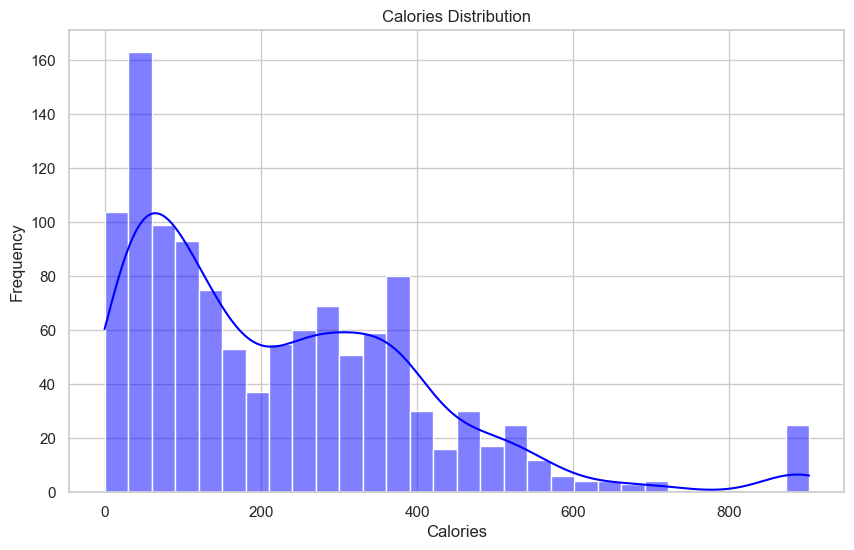

In [5]:

# 可視化 1: 繪製營養成分的分佈（例如卡路里）
plt.figure(figsize=(10, 6))
sns.histplot(df['Calories'], bins=30, kde=True, color='blue')
plt.title('Calories Distribution')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

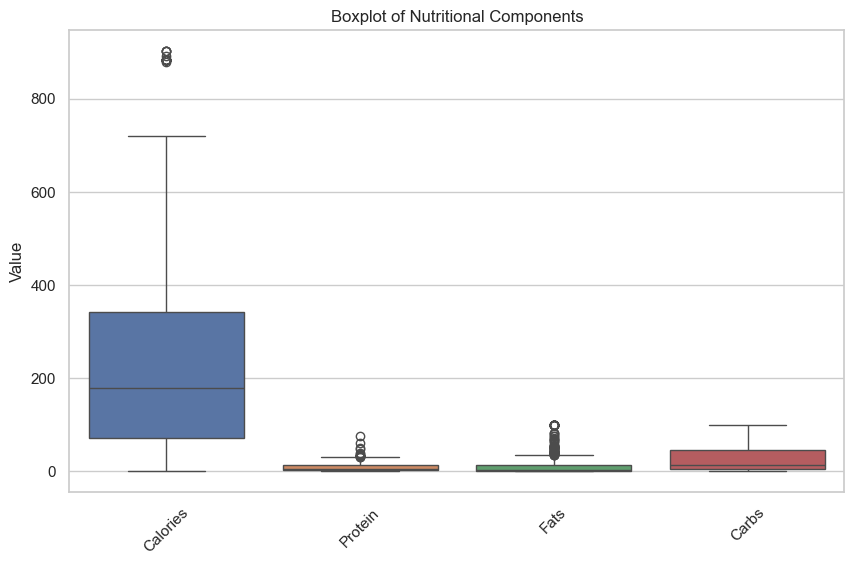

In [12]:
# 可視化 2: 繪製營養成分的箱型圖
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Calories', 'Protein', 'Fats', 'Carbs']])
plt.title('Boxplot of Nutritional Components')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 可視化 3: 繪製熱力圖顯示特徵之間的相關性
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [5]:
# 初始化 Flask 應用
app = Flask(__name__)

In [15]:
# 篩選與健康相關的重要特徵
selected_features = ['Food Name', 'Calories', 'Protein', 'Fats', 'Carbs', 'Fiber', 'Sugar']
df_selected = df[selected_features]

In [25]:
# 設定每日建議攝取量（DRI）的參考值（僅供示範，可根據需求修改）
base_dri = {
    'Calories': 2000,
    'Protein': 50,  # 單位：g
    'Fats': 70,      # 單位：g
    'Carbs': 300,  # 單位：g
    'Fiber': 25,    # 單位：g
    'Sugar': 50    # 單位：g
}

# 健康目標和活動水平的調整因子
goal_factor = {
    'weight_loss': 0.8,  # 減重時攝取量為基準的 80%
    'maintain': 1.0,     # 維持體重時攝取量保持基準
    'muscle_gain': 1.2   # 增肌時攝取量為基準的 120%
}

activity_factor = {
    'low': 0.9,   # 活動水平低
    'moderate': 1.0,  # 活動水平中等
    'high': 1.2   # 活動水平高
}
# 根據用戶輸入計算攝取情況
def generate_optimized_suggestions(input_foods, health_goal, activity_level):
    # input_foods 應是一個字典，記錄用戶的食物和攝取量。例如：
    # {'Food': ['Apple', 'Bread'], 'Quantity': [150, 200]} (單位：克)
    # 計算實際的 DRI 值
    adjusted_dri = {nutrient: base_dri[nutrient] * goal_factor[health_goal] * activity_factor[activity_level]
                    for nutrient in base_dri}
    # 合併用戶輸入與數據集
    user_data = pd.DataFrame(input_foods)
    merged_data = user_data.merge(df_selected, on='Food Name', how='left')

    # 計算用戶攝取的營養總量
    for col in ['Calories', 'Protein', 'Fats', 'Carbs', 'Fiber', 'Sugar']:
        merged_data[col] = merged_data[col] * merged_data['Quantity'] / 100  # 根據食物分量計算

    total_nutrition = merged_data[['Calories', 'Protein', 'Fats', 'Carbs', 'Fiber', 'Sugar']].sum()

    # 比較用戶攝取量與調整後的 DRI 值
    suggestions = {}
    for nutrient, dri_value in adjusted_dri.items():
        intake = total_nutrition[nutrient]
        if intake > dri_value:
            suggestions[nutrient] = f"Your {nutrient} intake is too high ({intake:.1f} vs {dri_value:.1f}). Reduce foods like {get_food_recommendation(df_selected, nutrient, 'low')}."
        elif intake < dri_value * 0.8:  # 如果攝取量低於建議量的 80%
            suggestions[nutrient] = f"Your {nutrient} intake is too low ({intake:.1f} vs {dri_value:.1f}). Increase foods like {get_food_recommendation(df_selected, nutrient, 'high')}."
        else:
            suggestions[nutrient] = f"Your {nutrient} intake is within the recommended range ({intake:.1f} vs {dri_value:.1f})."

    return suggestions

# 食品推薦邏輯
def generate_recommendations(data, nutrient, level):
    if level == 'high':
        recommended_foods = data.sort_values(by=nutrient, ascending=False).head(3)['Food Name'].tolist()
    elif level == 'low':
        recommended_foods = data.sort_values(by=nutrient).head(3)['Food Name'].tolist()
    return ', '.join(recommended_foods)
'''
# 示例：用戶輸入
user_input = {
    'Food Name': ['Apple', 'Bread', 'Chicken Breast'],
    'Quantity': [150, 200, 100]  # 單位：克
}

# 用戶目標與活動水平
health_goal = 'weight_loss'  # 可選：'weight_loss', 'maintain', 'muscle_gain'
activity_level = 'moderate'  # 可選：'low', 'moderate', 'high'

# 生成建議
optimized_suggestions = generate_optimized_suggestions(user_input, health_goal, activity_level)
print("優化健康建議：")
for nutrient, suggestion in optimized_suggestions.items():
    print(suggestion)
'''

'\n# 示例：用戶輸入\nuser_input = {\n    \'Food Name\': [\'Apple\', \'Bread\', \'Chicken Breast\'],\n    \'Quantity\': [150, 200, 100]  # 單位：克\n}\n\n# 用戶目標與活動水平\nhealth_goal = \'weight_loss\'  # 可選：\'weight_loss\', \'maintain\', \'muscle_gain\'\nactivity_level = \'moderate\'  # 可選：\'low\', \'moderate\', \'high\'\n\n# 生成建議\noptimized_suggestions = generate_optimized_suggestions(user_input, health_goal, activity_level)\nprint("優化健康建議：")\nfor nutrient, suggestion in optimized_suggestions.items():\n    print(suggestion)\n'

In [ ]:
import requests
# 定義 API 的 URL
url = "http://127.0.0.1:8080/recommendation"

# 測試數據
payload = {
  "foods": [
    {"Food Name": "Apple", "Quantity": 150},
    {"Food Name": "Chicken Breast", "Quantity": 200}
  ],
  "goal": "weight_loss",
  "activity": "moderate"
}


# 發送 POST 請求
response = requests.post(url, json=payload)

# 查看返回結果
if response.status_code == 200:
    print("API Response:")
    print(response.json())
else:
    print(f"Failed to connect to API. Status code: {response.status_code}")


Failed to connect to API. Status code: 500
